# Build convrnn

So we've downloaded the dataset and analyzed and visualized it. We're ready now for the next step: building the convrnn.

We first test it with a synthetic dataset: a ball that bounces.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from convlstm_pytorch import ConvLSTM
from synthetic_datasets import Ball
import utils

In [ ]:
# Give init parameters here
b = Ball()
# Calling an instance of Ball generates a batch of images
utils.plotting.plot_synthetic(b(sequence_length=10))

In [3]:
input_size = (100,100)
input_dim = 1
num_layers = 4
hidden_dim = [16,32,32,1]
kernel_size = (5,5)

# Meta params
learning_rate = .001
n_batches = 100
# TODO: Implement getting multiple batches of Ball() sequences
batch_size = 2
sequence_length = 6

convlstm = ConvLSTM(input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=False, use_cuda=False)

optim = torch.optim.Adam(convlstm.parameters(), lr=learning_rate)

losses = []

for i_b in range(n_batches):
    
    batch = np.ndarray((batch_size, sequence_length, 1, input_size[0], input_size[1]),
                      dtype=np.float32)
    
    for i_s in range(batch_size):
        # Shape now (t,w,h). Convert to floats
        sample = b(sequence_length=sequence_length).astype(np.float32)
        # Shape (t, c, h, w) where t is sequence length
        sample = sample[:, np.newaxis, :, :]
        # Shape (b, t, c, h, w)
        batch[i_s, :] = sample

    # Construct inputs/targets for all batches by shifting target left by 1
    inputs, targets = batch[:,:-1], batch[:,1:]

    inputs_var = torch.autograd.variable.Variable(torch.from_numpy(inputs), requires_grad=True)
    targets_var = torch.autograd.variable.Variable(torch.from_numpy(targets))

    layer_output_list, last_state_list = convlstm.forward(inputs_var)

    # CALCULATE ERROR
    loss_func = torch.nn.MSELoss()

    pred = last_state_list[-1][1]

    loss = loss_func(pred, targets_var[:,-1])
    
    optim.zero_grad()

    loss.backward()
    
    optim.step()

    print("Batch {:4d} loss: {:.5f}".format(i_b, loss.data[0]))
    losses.append(loss.data[0])


Batch 0 loss: 0.05830
Batch 1 loss: 0.08111
Batch 2 loss: 0.07858
Batch 3 loss: 0.12348
Batch 4 loss: 0.03149
Batch 5 loss: 0.12906
Batch 6 loss: 0.06747
Batch 7 loss: 0.04276
Batch 8 loss: 0.14109
Batch 9 loss: 0.06751
Batch 10 loss: 0.01966
Batch 11 loss: 0.09434
Batch 12 loss: 0.02514
Batch 13 loss: 0.03004
Batch 14 loss: 0.04601
Batch 15 loss: 0.10509
Batch 16 loss: 0.05122
Batch 17 loss: 0.03476
Batch 18 loss: 0.05035
Batch 19 loss: 0.08948
Batch 20 loss: 0.06572
Batch 21 loss: 0.06754
Batch 22 loss: 0.03761
Batch 23 loss: 0.02687
Batch 24 loss: 0.02008
Batch 25 loss: 0.02693
Batch 26 loss: 0.01920
Batch 27 loss: 0.10443
Batch 28 loss: 0.06360
Batch 29 loss: 0.07805
Batch 30 loss: 0.03511
Batch 31 loss: 0.03609
Batch 32 loss: 0.04282
Batch 33 loss: 0.02727
Batch 34 loss: 0.03182
Batch 35 loss: 0.04781
Batch 36 loss: 0.03685
Batch 37 loss: 0.03340
Batch 38 loss: 0.02823
Batch 39 loss: 0.03282
Batch 40 loss: 0.02174
Batch 41 loss: 0.01602
Batch 42 loss: 0.02558
Batch 43 loss: 0.0282

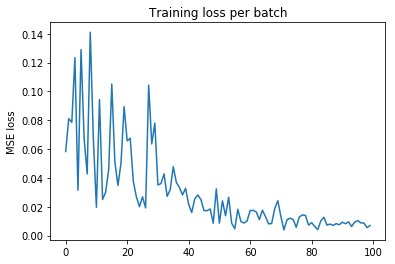

In [7]:
fig, ax = plt.subplots()
ax.set_title("Training loss per batch")
ax.set_ylabel('MSE loss')
ax.plot(losses)
plt.show()

In [ ]:
# PLOT OUTPUT
# Get hidden state from last output
pred = layer_output_list[0][0,-1,:]
# Extract FloatTensor from Variable, convert to numpy.ndarray
pred = pred.data.numpy()

# Take first of batch, channel axes
# targets is already np.array
t = targets[0,:,0]

imgs = np.concatenate((t,pred), axis=0)
# imgs = pred

utils.plotting.plot_synthetic(imgs, interval=500)